## Programación Cuadrática

Este cuaderno muestra varias formas de resolver el problema
de optimización de carteras modelado con programación cuadrática.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

### Datos

In [2]:
import pickle

In [3]:
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [4]:
close_dict = {tk: df.close for tk,df in stock_data.items()}
stock_close = pd.DataFrame(close_dict)

In [6]:
data_close = stock_close.loc['2019-01-02':'2019-12-31'].dropna(axis=1)

Para simplificar el ejercicio trabajaremos con un universo reducido
de 10 activos del IBEX.

In [7]:
data_close = data_close[['ACS','TEF','ITX','GRF','AMS','ENG','MAP','REP','AENA','VIS']]
data_close.head()

,ACS,TEF,ITX,GRF,AMS,ENG,MAP,REP,AENA,VIS
2019-01-02,29.254370,6.995052,21.723158,22.446920,59.910340,21.491329,2.062509,11.817150,131.210901,44.423518
2019-01-03,29.324778,7.111227,21.413242,22.525924,56.614491,21.759635,2.072394,11.833753,131.258788,44.290456
2019-01-04,29.764826,7.203789,22.168662,23.276459,58.564697,21.804353,2.130810,12.116003,134.563004,45.088825
2019-01-07,29.861636,7.268960,22.342990,23.256708,59.110755,21.786465,2.129911,12.016386,133.270050,45.240895
2019-01-08,30.169670,7.257626,22.827233,23.602349,60.612414,22.090546,2.127215,12.028838,134.084132,46.134308


___

Calculamos la media de los retornos logaritmicos y la matriz de covarianzas de los
retornos

In [8]:
returns = np.log(data_close).diff().dropna()
cov_returns = returns.cov()
mean_returns = returns.mean()

In [9]:
mean_returns

ACS     0.000481
TEF    -0.000458
ITX     0.001457
GRF     0.001325
AMS     0.000738
ENG     0.000054
MAP     0.000334
REP     0.000435
AENA    0.001031
VIS     0.000166
dtype: float64

In [10]:
cov_returns

,ACS,TEF,ITX,GRF,AMS,ENG,MAP,REP,AENA,VIS
ACS,0.000183,0.000066,0.000063,0.000042,0.000078,0.000024,0.000070,0.000081,0.000054,0.000084
TEF,0.000066,0.000118,0.000048,0.000011,0.000049,0.000027,0.000068,0.000057,0.000043,0.000035
ITX,0.000063,0.000048,0.000177,0.000054,0.000078,0.000029,0.000044,0.000061,0.000052,0.000064
GRF,0.000042,0.000011,0.000054,0.000178,0.000072,0.000016,0.000022,0.000022,0.000037,0.000047
AMS,0.000078,0.000049,0.000078,0.000072,0.000200,0.000037,0.000048,0.000065,0.000048,0.000067
ENG,0.000024,0.000027,0.000029,0.000016,0.000037,0.000207,0.000011,0.000028,0.000027,0.000033
MAP,0.000070,0.000068,0.000044,0.000022,0.000048,0.000011,0.000132,0.000060,0.000046,0.000040
REP,0.000081,0.000057,0.000061,0.000022,0.000065,0.000028,0.000060,0.000149,0.000033,0.000046
AENA,0.000054,0.000043,0.000052,0.000037,0.000048,0.000027,0.000046,0.000033,0.000105,0.000044
VIS,0.000084,0.000035,0.000064,0.000047,0.000067,0.000033,0.000040,0.000046,0.000044,0.000301


___

#### Espacio de posibles carteras
Simulamos primero un conjunto aleatorio de pesos para visualizar el espacio
de posibles carteras 

In [11]:
n = mean_returns.shape[0]
list_ret_p = []
list_std_p = []
list_w = []
for _ in range(10000):
    w = np.random.rand(n)           # pesos aleatorios   
    w = w / np.sum(w)               # Escalamos para que sumen 1
    ret_p = mean_returns.dot(w)
    std_p = np.sqrt(w @ cov_returns.values @ w)  
    list_ret_p.append(ret_p)
    list_std_p.append(std_p)
    list_w.append(w)

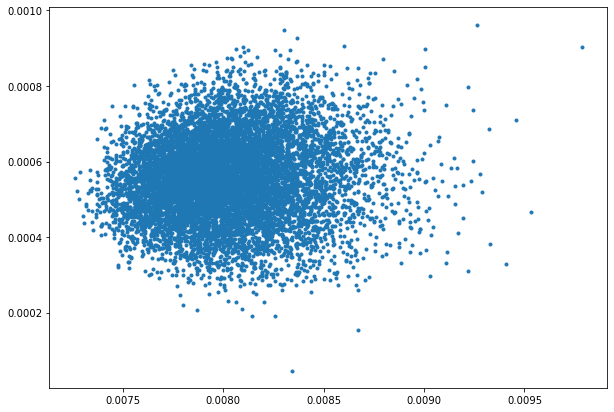

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_ret_p, '.')

In [13]:
list_w[0]

array([0.01870919, 0.02224464, 0.26672112, 0.0488362 , 0.17427109,
       0.1662756 , 0.08141736, 0.06562055, 0.04582214, 0.11008212])

___

### Cartera de Varianza Mínima 
Primero haremos un modelo para construir la cartera
de varianza mínima

In [15]:
Sigma = cov_returns.values
mu = mean_returns.values

In [16]:
mu

array([ 4.81437937e-04, -4.57906755e-04,  1.45677205e-03,  1.32523400e-03,
        7.37896970e-04,  5.36658049e-05,  3.33621780e-04,  4.34764119e-04,
        1.03121787e-03,  1.66018491e-04])

In [17]:
w = cp.Variable(n)

port_risk = cp.quad_form(w, Sigma)
port_ret = mu @ w
constraints = [
    cp.sum(w) == 1, 
    w >= 0
]
prob = cp.Problem(cp.Minimize(port_risk), 
                  constraints) 
prob.solve()

5.1592934377716594e-05

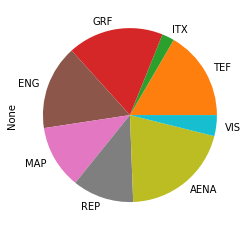

In [18]:
cartera = pd.Series(w.value, index=returns.columns).round(3)
cartera.plot.pie()

In [19]:
cartera

ACS    -0.000
TEF     0.166
ITX     0.023
GRF     0.178
AMS    -0.000
ENG     0.157
MAP     0.118
REP     0.114
AENA    0.205
VIS     0.039
dtype: float64

In [20]:
port_risk.value, port_ret.value

(5.1592934377716594e-05, 0.0005079736011967322)

Vemos donde se situa el portfolio de varianza mínima en el 
espacio de carteras

In [21]:
port_std = np.sqrt(port_risk.value)
port_return =  port_ret

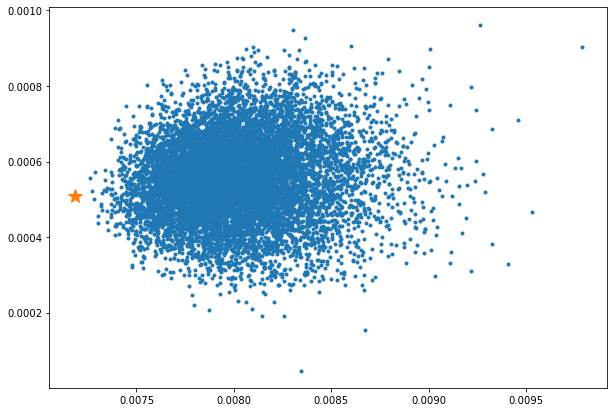

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_ret_p, '.')
ax.plot(port_std, port_return.value, '*', markersize=15)

___

### Calculo de la Frontera Eficiente

In [23]:
def efficient_frontier(returns, n_samples=50, gamma_low=-1, gamma_high=10):
    """
    construye un conjunto de problemas de programación cuádrática
    para inferir la frontera eficiente de Markovitz. 
    En cada problema el parámetro gamma se cambia para aumentar
    la penalización del riesgo en la función de maximización.
    """
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values  
    n = sigma.shape[0]        
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, sigma)
    
    prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                      [cp.sum(w) == 1,  w >= 0]) 
    # Equivalente 
    #prob = cp.Problem(cp.Minimize(risk - gamma*ret), 
    #                  [cp.sum(w) == 1,  w >= 0])   
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(gamma_low, gamma_high, num=n_samples)
    
    portfolio_weights = []    
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)   
    return ret_data, risk_data, gamma_vals, portfolio_weights



In [24]:
ret_data, risk_data, gamma_vals, portfolio_weights = efficient_frontier(returns)

In [25]:
gamma_vals.round(3)

array([1.00000000e-01, 1.68000000e-01, 2.81000000e-01, 4.71000000e-01,
       7.91000000e-01, 1.32600000e+00, 2.22300000e+00, 3.72800000e+00,
       6.25100000e+00, 1.04810000e+01, 1.75750000e+01, 2.94710000e+01,
       4.94170000e+01, 8.28640000e+01, 1.38950000e+02, 2.32995000e+02,
       3.90694000e+02, 6.55129000e+02, 1.09854100e+03, 1.84207000e+03,
       3.08884400e+03, 5.17947500e+03, 8.68511400e+03, 1.45634850e+04,
       2.44205310e+04, 4.09491510e+04, 6.86648850e+04, 1.15139540e+05,
       1.93069773e+05, 3.23745754e+05, 5.42867544e+05, 9.10298178e+05,
       1.52641797e+06, 2.55954792e+06, 4.29193426e+06, 7.19685673e+06,
       1.20679264e+07, 2.02358965e+07, 3.39322177e+07, 5.68986603e+07,
       9.54095476e+07, 1.59985872e+08, 2.68269580e+08, 4.49843267e+08,
       7.54312006e+08, 1.26485522e+09, 2.12095089e+09, 3.55648031e+09,
       5.96362332e+09, 1.00000000e+10])

### Cartera Óptima
Para determinar la **cartera con mejor ratio sharpe**, sacamos todos los
ratios Sharpe y elegimos donde ocurre el máximo

In [28]:
sharpes = ret_data/risk_data 
idx = np.argmax(sharpes)
optimal_ret, optimal_risk = ret_data[idx], risk_data[idx]
optimal_portfolio = pd.Series(portfolio_weights[idx],
                              index=returns.columns).round(3)

In [29]:
sharpes

array([0.10944438, 0.10944438, 0.10944438, 0.10944438, 0.1196067 ,
       0.126317  , 0.12869699, 0.13602583, 0.13948561, 0.13899801,
       0.12962189, 0.11882909, 0.10603361, 0.09257577, 0.08399414,
       0.07871126, 0.07551017, 0.07358502, 0.07243161, 0.07174195,
       0.07133004, 0.07108417, 0.07093747, 0.07084995, 0.07079775,
       0.07076662, 0.07074805, 0.07073698, 0.07073037, 0.07072643,
       0.07072409, 0.07072268, 0.07072185, 0.07072135, 0.07072105,
       0.07072088, 0.07072077, 0.07072071, 0.07072067, 0.07072065,
       0.07072063, 0.07072063, 0.07072062, 0.07072062, 0.07072062,
       0.07072062, 0.07072062, 0.07072062, 0.07072062, 0.07072062])

Dibujamos la frontera eficiente y donde ocurre la cartera optima

In [30]:
optimal_portfolio

ACS     0.000
TEF     0.000
ITX     0.364
GRF     0.316
AMS     0.000
ENG     0.000
MAP     0.000
REP     0.000
AENA    0.320
VIS    -0.000
dtype: float64

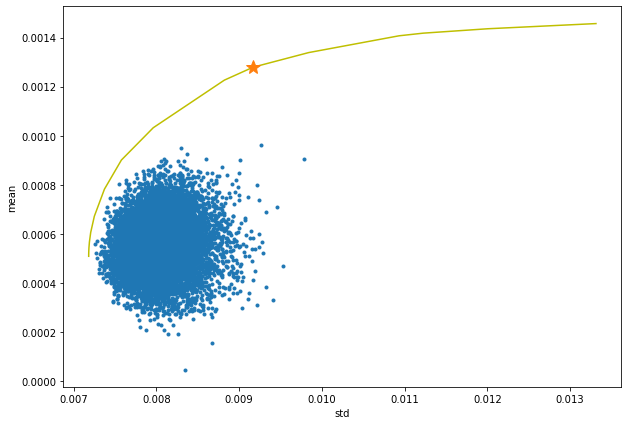

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(list_std_p, list_ret_p, '.')
ax.plot(risk_data, ret_data, 'y')
ax.plot(optimal_risk, optimal_ret, '*', markersize=15)
_ = ax.set_xlabel('std')
_ = ax.set_ylabel('mean')


In [ ]:
optimal_portfolio.plot.pie()

In [ ]:
optimal_portfolio

___

### Ejercicios Propuestos

1. Para evitar posiciones grandes que puedan surgir en la cartera óptima limitaremos 
el tamaño máximo que se puede asignar a cada peso.  Para este ejercicio proponemos:
    - modificar la función de la frontera eficiente para que acepte las restricciones de peso máximo y peso mínimo por posición 
    - añadir al gráfico original las fronteras eficientes correspondientes a carteras que tienen posiciones máximas de 20 y 15%
2. Para centrarnos en empresas de más capitalización hemos decidido que las empresas que tienen menos de 10 mil millones de capitalización no deben sumar más del 25% de la cartera. En nuestro universo de activos esto corresponde a ACS, MAP, ENG y VIS. Determine cuál es la cartera de mínimo riesgo tomando en cuenta estas restricciones